In [9]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

from argparse import ArgumentParser
import os

from model.datasets import get_CIFAR10
from model.ddpm import DDPM
from model.v2.unet import Unet
from model.training import train, sample
from model.utils import SaveBestModel, load_model, plot_images
from model.metrics import fid_score

import gc
from tqdm.notebook import tqdm

In [6]:
torch.cuda.empty_cache()
gc.collect()

1031

In [2]:
CUDA = 0
batch_size = 32

dataloader = get_CIFAR10(batch_size=batch_size)
device = torch.device(f"cuda:{CUDA}" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [3]:
device

device(type='cuda', index=0)

In [45]:
unet = Unet(T=100, n_channels=128, channels_mul=[1, 2, 2, 2], n_residual_blocks=2, dropout=0.1).to(device)
model = DDPM(unet, device=device)


In [46]:
model.load_state_dict(torch.load('bin/cifar10.pth')['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for DDPM:
	size mismatch for model.time_embedding.timembedding.0.weight: copying a param with shape torch.Size([1000, 128]) from checkpoint, the shape in current model is torch.Size([100, 128]).

In [44]:
n_batches = 10
n_samples = n_batches * batch_size

img_shape = dataloader.dataset[0][0].shape
fake_data = sample(model, n_samples, img_shape, batch_size, device)

Going to sample 10 batches
Sampling 1 batch...


100%|██████████| 1000/1000 [01:40<00:00,  9.90it/s]


Sampling 2 batch...


100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


Sampling 3 batch...


 58%|█████▊    | 577/1000 [00:58<00:43,  9.80it/s]


KeyboardInterrupt: 

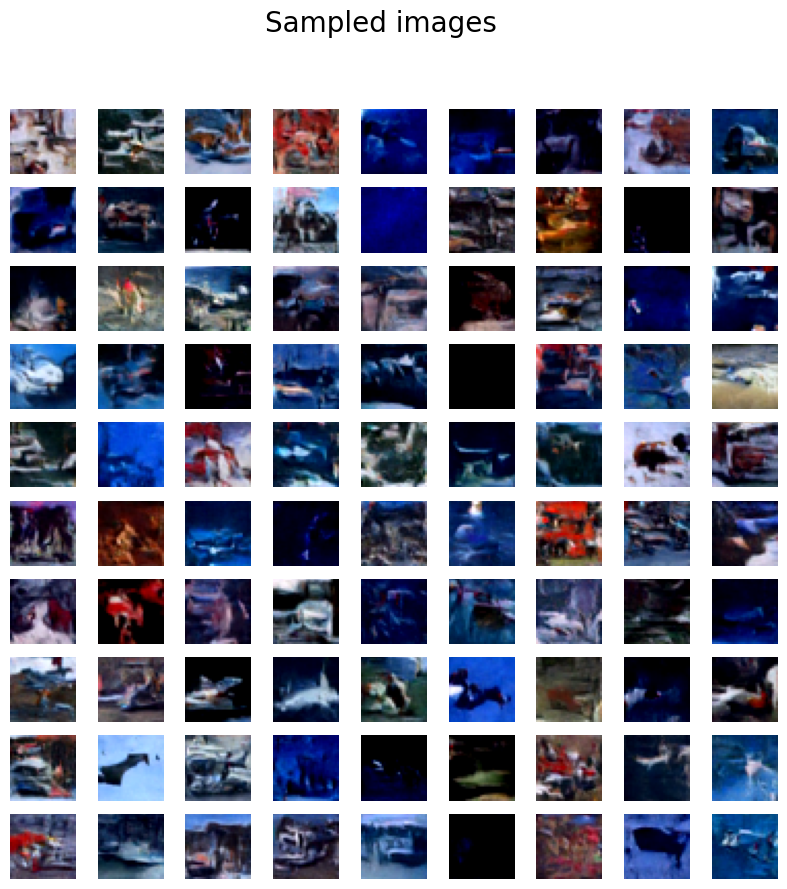

In [37]:
plot_images(fake_data, "Sampled images", output_filename="sampled.png")

In [41]:
real_data = []

i = 0
for images, _ in dataloader:
    if i == 3:
        break
    real_data.append(images)
    i += 1

real_data = torch.cat(real_data, dim=0)

In [42]:
real_data.shape

torch.Size([96, 3, 32, 32])

In [43]:
fid = fid_score(real_data, fake_data)
fid

100%|██████████| 3/3 [00:00<00:00, 18.84it/s]


562.2919921875